In [1]:
import sys
import os

# Add the 'src' directory to sys.path
sys.path.append(os.path.abspath("/home/b/b383073/solar_indicator/src"))

# Now import modules (WITHOUT `.` in import paths)
from core import get_type, convert_temperature
from solar_resource import (
    compute_sol_res_avail,
    compute_bright_sunshine_hours,
    compute_episode_length,
    compute_percentage_continuity
)
from pv_potential import pv_pot
from tcell import Tcell_hourly, Tcell_daily_mean, Tcell_daily_max, efficiency_derating_days

print("Modules imported successfully!")


Modules imported successfully!


In [3]:
# Compute PV Potential
pv_output = pv_pot(
    temp_file="/scratch/b/b383073/ERA5_Data_Scien/ERA5_hourly/tas_199001.nc",
    rad_file="/scratch/b/b383073/ERA5_Data_Scien/ERA5_hourly/rsds_regridded_linear_199001.nc",
    wind_file="/scratch/b/b383073/ERA5_Data_Scien/ERA5_hourly/sfcWind_199001.nc"
)

print("PV Potential computed successfully!")


PV Potential computed successfully!


In [4]:
print(pv_output)

<xarray.DataArray 'PVP' (time: 744, lat: 640, lon: 1280)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.5942302 , 0.5942218 , 0.59421355, ..., 0.5942718 ,
         0.5942579 , 0.59424406],
        [0.60400957, 0.60399985, 0.60399014, ..., 0.60400635,
         0.6040157 , 0.6040002 ],
        [0.61531335, 0.6152974 , 0.6153064 , ..., 0.6152862 ,
         0.61529523, 0.6153043 ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [0.36704087, 0.36605752, 0.36507434, ..., 0.3678620

In [ ]:
# save the ouput to a netcdf 

pv_output.to_netcdf("/scratch/b/b383073/ERA5_Data_Scien/ERA5_hourly/PV_pot_199001.nc")
print("PV Potential saved successfully!")


In [8]:
#daily mean
pv_daily_mean = pv_output.resample(time="1D").mean()
print("Daily mean PV potential computed successfully!")
import numpy as np
print("Shape of pv_daily_mean:", np.shape(pv_daily_mean))

Daily mean PV potential computed successfully!
Shape of pv_daily_mean: (31, 640, 1280)


In [5]:
#Plotting libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from cmocean import cm as cmo
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from matplotlib.ticker import ScalarFormatter
import matplotlib.patches as patches
import matplotlib.colors as mpc
%matplotlib inline


# Use the plot_map function to visualize wind_speed_weekly_mean at level 100
def plot_map(data, xmin, xmax, colormap, label, title, delta=12, projection='robinson', type='pcolormesh', extend='neither', ax=None):
    """
    Plot a map of a variable using Robinson projection (or other projections) with customizable colorbars and plot types.

    Input
    -------
    data: xarray.DataArray ; (lat,lon)
        Data array to plot.
    xmin: float
        Minimum value of the colorbar.
    xmax: float
        Maximum value of the colorbar.
    colormap: str or Colormap
        Colormap to use.
    label: str
        Label of the colorbar.
    title: str
        Title of the plot.
    delta: int
        Number of ticks in the colorbar (delta/2).
    projection: str
        Projection type, 'robinson' for global, 'mollweide', or 'platecarree' for specific regions.
    type: str
        Type of plot, 'pcolormesh' or 'contourf'.
    extend: str
        Extend of the colorbar. Options are 'neither', 'both', 'min', 'max'.
    ax: matplotlib axis object, optional
        Axis on which to plot. If None, creates a new axis.

    Output
    -------
    Plot of the variable.
    """
    # Choose the projection
    if projection == 'robinson':
        proj = ccrs.Robinson()
    elif projection == 'mollweide':
        proj = ccrs.Mollweide()
    elif projection == 'platecarree':
        proj = ccrs.PlateCarree()
    else:
        raise ValueError("Unsupported projection type. Use 'robinson', 'mollweide', or 'platecarree'.")

    # Create the figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 10), subplot_kw={'projection': proj})  # Make the figure larger

    # Extract lat and lon from the DataArray
    lats = data.lat.values
    lons = data.lon.values
    var = data.values

    # Add a cyclic point to avoid gaps in the plot near longitude 360
    var, lons = add_cyclic_point(var, coord=lons)
    # Create the meshgrid for lat/lon
    lon2d, lat2d = np.meshgrid(lons, lats)

    # Plot based on the type parameter
    if type == 'pcolormesh':
        cs = ax.pcolormesh(lon2d, lat2d, var, transform=ccrs.PlateCarree(), cmap=colormap, vmin=xmin, vmax=xmax)
    elif type == 'contourf':
        clevs = np.linspace(xmin, xmax, 256)
        cs = ax.contourf(lon2d, lat2d, var, levels=clevs, cmap=colormap, extend=extend, transform=ccrs.PlateCarree())
        ax.contour(lon2d, lat2d, var, clevs, colors='k', linewidths=0.5, transform=ccrs.PlateCarree())

    # Add light coastlines and land features
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='whitesmoke')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.75, edgecolor='black')

    # Add latitude and longitude gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable labels at the top
    gl.right_labels = False  # Disable labels on the right side
    gl.xlabel_style = {'size': 12}  # Customize longitude labels/home/bsc/bsc148104/
    gl.ylabel_style = {'size': 12}  # Customize latitude labels

    # Add colorbar--------------------------------------------------------------------------

    cbar = plt.colorbar(cs, ax=ax, orientation='horizontal', pad=0.05, extend=extend, shrink=0.7)  # Shrink the colorbar width
    cbar.set_label(label)

    # Customize the colorbar ticks
    cbar.ax.tick_params(labelsize=12)
    tick_locator = plt.MaxNLocator(nbins=int(delta / 2))  # Adjust tick density
    cbar.locator = tick_locator
    cbar.update_ticks()

    # Set the titlepv_output.to_netcdf("/scratch/b/b383073/ERA5_Data_Scien/ERA5_hourly/PV_pot_199001.nc")
print("PV Potential saved successfully!")
    plt.title(title)

    # Show the plot
    plt.show()



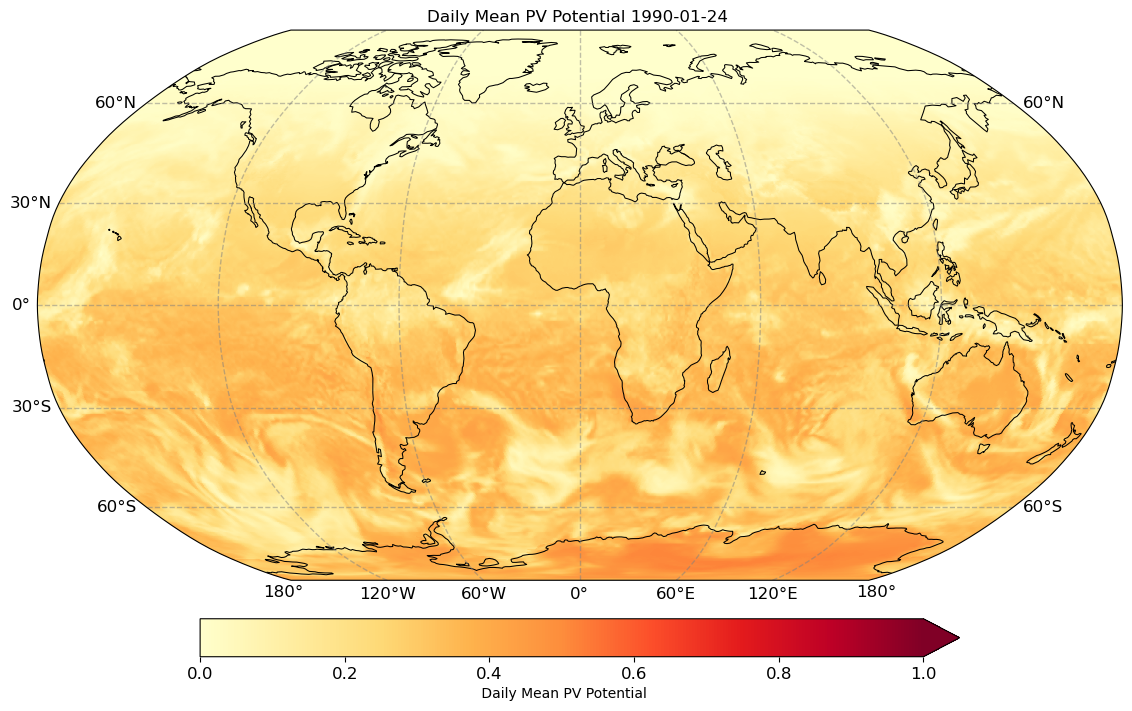

In [10]:
plot_map(
    pv_daily_mean.isel(time=25),             # Select the first level
    xmin=0, xmax=1,                         # Set the range for the colorbar
    colormap="YlOrRd",                  # Use the custom Global Wind Atlas colormap
    label=' Daily Mean PV Potential',                # Label for the colorbar
    title='Daily Mean PV Potential 1990-01-24 ',                               # Title for the plot
    projection='robinson',                  # Use the Robinson projection for global plotting
    type='pcolormesh',                      # Type of plot (pcolormesh for grid-based plot)
    extend='max'                        # Extend colorbar for values beyond limits
)